# AMLO and López-Gatell: Twitter Sentiment Analysis

Constantino Carreto 

In this project I implement sentiment analysis for tweets mentioning **AMLO** or **López-Gatell**. I conected to twitter API on january saturday 9, 2021, at 19:30 - 23:30 hours, and downloaded tweets containing these words. I try to compare the posivite/negative feelings expressed in tweets mentioning _AMLO_ versus tweets mentioning _López-Gatell_ in order to verify whether _López-Gatell_, the Undersecretary of Prevention and Health Promotion is better evaluated by public opinion, compared to the president. 

Results show that: i) opinion for both subjects is negative during the daily Covid Conference, but when the conference ends, opinion improves; ii) opinion for _López-Gatell_ is highly correlated to opinion for the president. Nontheless, _López-Gatell_ scores better since during the analysis period, opinions for him are on average neutral, while opinios for the president are slightly negative.

In [1]:
# libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import time

# for twitter
from tweepy import OAuthHandler
from tweepy import API

# to instantiate the Stream object
from tweepy import Stream

# for the Slistener module:
from tweepy.streaming import StreamListener
import json
import time
import sys

# Load SentimentIntensityAnalyzer (sentiment analysis)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# for the translator API
import requests

print('libraries imported')

libraries imported


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tino_\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Twitter Streaming

In [2]:
# set working directory to save file
default_wd=os.getcwd()
os.chdir('F:/practicas_python/twitter_streaming')

# Store OAuth authentication credentials in relevant variables
# API_key
# also referred as: consumer_key
API_key='qMGXCULhq6Nrqb8aTY3PJLC3L'
# API_key_secret
# also referred as: consumer_secret
API_key_secret='2WpN6dlycrdSUKjAIqxrfy0TVMzqUcvN3RaM5OJKFHbbe8a7tE'
bearer_token='AAAAAAAAAAAAAAAAAAAAAEipGwEAAAAAITXMa%2FGRLqJGZ87cRRAQXMUGPGE%3DHUXoMQcC8N5sjtjqBcw85mCOiiFhX33IoZZB6Wo4UZnPE6Yxmz'
access_token='2321809326-eeMt3d2qX1ZjbkCDkl9xqi74knYxicHkG6OC76l'
access_token_secret='lG2EDsDFjydo2krZd165xdK78R9YYAntwEsCpRIsNQVuj'

# Consumer key authentication
auth = OAuthHandler(API_key, API_key_secret)

# Access key authentication
auth.set_access_token(access_token, access_token_secret)

# Set up the API with the authentication handler
api = API(auth)

Define the SListener module.

In [3]:
class SListener(StreamListener):
    def __init__(self, api = None, fprefix = 'streamer'):
        self.api = api or API()
        self.counter = 0
        self.fprefix = fprefix
        self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')


    def on_data(self, data):
        if  'in_reply_to_status' in data:
            self.on_status(data)
        elif 'delete' in data:
            delete = json.loads(data)['delete']['status']
            if self.on_delete(delete['id'], delete['user_id']) is False:
                return False
        elif 'limit' in data:
            if self.on_limit(json.loads(data)['limit']['track']) is False:
                return False
        elif 'warning' in data:
            warning = json.loads(data)['warnings']
            print("WARNING: %s" % warning['message'])
            return


    def on_status(self, status):
        self.output.write(status)
        self.counter += 1
        if self.counter >= 20000:
            self.output.close()
            self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')
            self.counter = 0
        return


    def on_delete(self, status_id, user_id):
        print("Delete notice")
        return


    def on_limit(self, track):
        print("WARNING: Limitation notice received, tweets missed: %d" % track)
        return


    def on_error(self, status_code):
        print('Encountered error with status code:', status_code)
        return 


    def on_timeout(self):
        print("Timeout, sleeping for 60 seconds...")
        time.sleep(60)
        return 

Start to Stream tweets

In [12]:
# Set up words to track
keywords_to_track = ['AMLO', 'amlo', 'López Obrador', 'López-Gatell', 'Gatell', 'gatell']

# Instantiate the SListener object 
listen = SListener(api)

# Instantiate the Stream object
stream = Stream(auth, listen)

# Begin collecting data
stream.filter(track = keywords_to_track)

## other options
#stream.filter(track = keywords_to_track, languages=['es'])
# go to: http://gettwitterid.com/
#stream.filter(follow=["2321809326"]) # Constantino
# sample de todos los tweets existentes
#stream.sample()

### buliding the tweets database

Since tweets contained in a file are stored as a single json file, we create a function that split those tweets and keep them in a list

In [4]:
# functions that separate tweets
def clean_list(raw_data):
    '''
    separate tweets and generate a list of dictionaries,
    where every dictionary is a tweet
    '''
    files_list=[]
    for archivo in raw_data:
    
        # leemos el archivo json arrojado por el streamer
        with open(archivo,'r') as file:
            read_file = file.read() 
        # limpiamos el archivo
        read_file2=read_file.split('\n')
        tweets = []
        for line in read_file2:
            if len(line)!=0:
                tweets.append(line)
        # creamos lista con archivos json
        tweets_json = []    
        for line in tweets:
            tweets_json.append(json.loads(line))
        files_list.append(tweets_json)
    # return the whole list
    flat_list = [item for sublist in files_list for item in sublist]
    return flat_list


In [5]:
# define list of files to process
# look for the names in your working directory
lista_jsons=['streamer_20210109-193213.json',
              'streamer_20210109-200143.json',
              'streamer_20210109-200239.json']

tweets_json = clean_list(lista_jsons)

In [6]:
# how many tweets?
print('file contains {} tweets'.format(len(tweets_json)))

file contains 19316 tweets


Let's see some features from a single tweet

In [7]:
print(tweets_json[11]['text'], '\n ----------------')
print(tweets_json[11]['extended_tweet']['full_text'], '\n------------------')
print(tweets_json[11]['id'])

Aquí va, esto es lo que yo no entiendo ... 

https://t.co/olfGY0c2aY

Si amlo sabía desde hace mucho de esos delito… https://t.co/PRURfD2DbR 
 ----------------
Aquí va, esto es lo que yo no entiendo ... 

https://t.co/olfGY0c2aY

Si amlo sabía desde hace mucho de esos delitos porque no denunció ?? Porque no hace nada ahora que es presidente ?? 

A mi me hace pensar o que es parte de eso o que es incompetente. 
------------------
1348080195866140674


In [8]:
# Print user handle
print(tweets_json[11]['user']['screen_name'])
# Print user follower count
print(tweets_json[11]['user']['followers_count'])
# Print user location
print(tweets_json[11]['user']['location'])
# Print user description
print(tweets_json[11]['user']['description'])

tamezjorge
20804
Donde haya WiFi Gratis
Buscando el bien de nuestros semejantes, encontramos el nuestro - Platón. Si quieren cita con el Nutriologo porfa llamen al 8110423076 (Whatsapp)


In [9]:
# Print the text of a tweet which has been retweeted
print(tweets_json[14]['retweeted_status']['text'])

@SinLinea_Mx Estos gobernadores prianistas parecen corderitos cuando tienen enfrente a AMLO. Tuve la oportunidad de… https://t.co/Xg6qP2tPkf


In [10]:
# Print a quoted tweet text
print(tweets_json[11]['quoted_status']['text'], '\n----------------')
# Print the quoted tweet's extended (140+) text
print(tweets_json[11]['quoted_status']['extended_tweet']['full_text'], '\n----------------')
# Print the quoted user location
print(tweets_json[11]['quoted_status']['user']['location'])

@o_cantu_70 @tamezjorge No pude haberlo dicho mejor.

El tiempo pondrá a todos en su lugar... de hecho ya los está… https://t.co/Lcg3AFsRzO 
----------------
@o_cantu_70 @tamezjorge No pude haberlo dicho mejor.

El tiempo pondrá a todos en su lugar... de hecho ya los está poniendo, pero una lamentable combinacion de prejuicios e ignorancia que impiden ver la realidad y el potencial de Mexico, que no ha explotado por la gestión rapaz que hemos padecido, sigue 
----------------
None


In [11]:
# vemos los valores para cada llave un tweet especifico
for key in tweets_json[11].keys():
    print(key +' ::::::::::::::' +'\n'+ str(tweets_json[11][key]))

created_at ::::::::::::::
Sun Jan 10 01:32:19 +0000 2021
id ::::::::::::::
1348080195866140674
id_str ::::::::::::::
1348080195866140674
text ::::::::::::::
Aquí va, esto es lo que yo no entiendo ... 

https://t.co/olfGY0c2aY

Si amlo sabía desde hace mucho de esos delito… https://t.co/PRURfD2DbR
source ::::::::::::::
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
truncated ::::::::::::::
True
in_reply_to_status_id ::::::::::::::
None
in_reply_to_status_id_str ::::::::::::::
None
in_reply_to_user_id ::::::::::::::
None
in_reply_to_user_id_str ::::::::::::::
None
in_reply_to_screen_name ::::::::::::::
None
user ::::::::::::::
{'id': 158251941, 'id_str': '158251941', 'name': 'Jorge Tamez', 'screen_name': 'tamezjorge', 'location': 'Donde haya WiFi Gratis', 'url': 'http://www.zebien.com', 'description': 'Buscando el bien de nuestros semejantes, encontramos el nuestro - Platón. Si quieren cita con el Nutriologo porfa llamen al 8110423076 (Whatsapp)', 'tra

Now, let's flatten the tweets file, so every tweet's feature of interest is directly accesible in every tweet's dictionary  

In [12]:
def flatten_tweets(tweets_json):
    """ Flattens out tweet dictionaries so relevant JSON
        is in a top-level dictionary."""
    tweets_list = []
    
    # Iterate through each tweet
    for tweet_obj in tweets_json:
        #tweet_obj = json.loads(tweet)
    
        # Store the user screen name in 'user-screen_name'
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
    
        # Check if this is a 140+ character tweet
        tweet_obj['extended_tweet-full_text']=''
        if 'extended_tweet' in tweet_obj:
            # Store the extended tweet text in 'extended_tweet-full_text'
            tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
        
        tweet_obj['retweeted_status-user-screen_name']=''
        tweet_obj['retweeted_status-text']=''
        tweet_obj['retweeted_status-extended_tweet-full_text']=''
        if 'retweeted_status' in tweet_obj:
            # Store the retweet user screen name in 'retweeted_status-user-screen_name'
            tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
         
            if 'extended_tweet' in tweet_obj['retweeted_status']:
                tweet_obj['retweeted_status-extended_tweet-full_text']=tweet_obj['retweeted_status']['extended_tweet']['full_text']
         
        # quoted status
        tweet_obj['quoted_status-text']=''
        tweet_obj['quoted_status-extended_tweet-full_text']=''
        if 'quoted_status' in tweet_obj:
            # 
            tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text']
            if 'extended_tweet' in tweet_obj['quoted_status']:
                tweet_obj['quoted_status-extended_tweet-full_text'] = tweet_obj['quoted_status']['extended_tweet']['full_text']
            
        tweets_list.append(tweet_obj)
    return tweets_list


In [13]:
# Flatten the tweets and store them in `tweets`
tweets = flatten_tweets(tweets_json)

# Create a DataFrame from `tweets`
ds_tweets_aux = pd.DataFrame(tweets)

# Print out the first 5 tweets from this dataset
print(ds_tweets_aux['text'].values[0:5])

['RT @GlodeJo07: El incendio en el centro de control en el metro de la CDMX se debe al pésimo o nulo mantenimiento de los gobiernos anteriore…'
 'RT @kataleyazi: El apoyo real hacia el presidente #AMLO  se ve en la calle, promoviendo los grandes avances de la 4T, con nuestros familiar…'
 'RT @Mike_Oviedo: AMLO aseguró que vacuna contra corrupción está en fase 3.\n\nY con nuestro voto, exterminemos el TUMOR que nos sumergió en e…'
 'RT @Vampiroperver: Loretito de mola es la cura internacional\n\n#RedAMLO \n#AMLO https://t.co/ZKPmWrcwys'
 'RT @DomadorDChairos: #AMLOEnfermoMental']


### Count word occurrencies

We count the number of ocurrencies for 'AMLO' and 'Gatell' and plot them

In [14]:
# find mentions of a word
word='Gatell' # escribirlo en ingles

word_o = ds_tweets_aux['text'].str.contains(word, case=False)
# Print proportion of tweets mentioning that word
print("Proportion of {} tweets:".format(word),
      np.sum(word_o) / ds_tweets_aux.shape[0])

Proportion of Gatell tweets: 0.04162352453924208


In [15]:
# define function to count word ocurrencies
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series.
    """
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False)
    contains_column |= data['retweeted_status-extended_tweet-full_text'].str.contains(word, case = False)
    return contains_column

In [16]:
# Find mentions of amlo in all text fields
amlo = check_word_in_tweet('amlo', ds_tweets_aux)

# Find mentions of gatell in all text fields
gatell = check_word_in_tweet('gatell', ds_tweets_aux)

# Print proportion of tweets mentioning amlo
print("Proportion of {} tweets:".format('amlo'), np.sum(amlo) / ds_tweets_aux.shape[0])

# Print proportion of tweets mentioning gatell
print("Proportion of {} tweets:".format('gatell'), np.sum(gatell) / ds_tweets_aux.shape[0])


Proportion of amlo tweets: 0.7007144336301512
Proportion of gatell tweets: 0.0958790639884034


In [17]:
# restrict database to only tweets with any of word1 or word2
ds_tweets = ds_tweets_aux.loc[amlo | gatell,:]

# Find mentions of amlo in all text fields
amlo = check_word_in_tweet('amlo', ds_tweets)

# Find mentions of gatell in all text fields
gatell = check_word_in_tweet('gatell', ds_tweets)

# Print proportion of tweets mentioning amlo
print("Proportion of {} tweets:".format('amlo'), np.sum(amlo) / ds_tweets.shape[0])

# Print proportion of tweets mentioning gatell
print("Proportion of {} tweets:".format('gatell'), np.sum(gatell) / ds_tweets.shape[0])

Proportion of amlo tweets: 0.9106506088945704
Proportion of gatell tweets: 0.12460472313799367


Prepare for plotting

In [18]:
# Print created_at to see the original format of datetime in Twitter data
print(ds_tweets['created_at'].head())
# Convert the created_at column to np.datetime object
ds_tweets['created_at'] = pd.to_datetime(ds_tweets['created_at'])
# Print created_at to see new format
print(ds_tweets['created_at'].head())
# fix the time zone gap
d = timedelta(hours=6) # cdmx is 6 hours behind UTC
ds_tweets['created_at'] = ds_tweets['created_at'] - d
# Set the index of ds_tweets to created_at
ds_tweets = ds_tweets.set_index('created_at')
print(ds_tweets.index.values[0:5])
# Create a word1 column
ds_tweets['amlo'] = check_word_in_tweet('amlo', ds_tweets)
# Create an word2 column
ds_tweets['gatell'] = check_word_in_tweet('gatell', ds_tweets)
# Average of word1 column by minute
mean_amlo = ds_tweets['amlo'].resample('10 min').mean()
# Average of rstats column by day
mean_gatell = ds_tweets['gatell'].resample('10 min').mean()

1    Sun Jan 10 01:32:15 +0000 2021
2    Sun Jan 10 01:32:16 +0000 2021
3    Sun Jan 10 01:32:16 +0000 2021
4    Sun Jan 10 01:32:16 +0000 2021
5    Sun Jan 10 01:32:17 +0000 2021
Name: created_at, dtype: object


C:\Users\tino_\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\tino_\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


1   2021-01-10 01:32:15+00:00
2   2021-01-10 01:32:16+00:00
3   2021-01-10 01:32:16+00:00
4   2021-01-10 01:32:16+00:00
5   2021-01-10 01:32:17+00:00
Name: created_at, dtype: datetime64[ns, UTC]
['2021-01-09T19:32:15.000000000' '2021-01-09T19:32:16.000000000'
 '2021-01-09T19:32:16.000000000' '2021-01-09T19:32:16.000000000'
 '2021-01-09T19:32:17.000000000']


Now, let's plot word occurencies

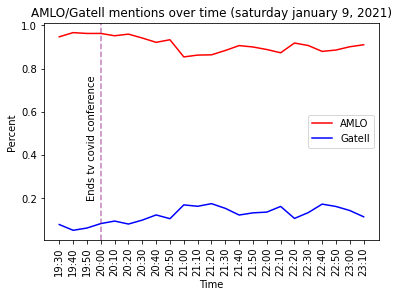

In [19]:
'''
We plot the percentage of occurencies of word1 (word2)
respect to the total number of tweets that mention word1 or word2.
Remember these tweets are only 1% of total real tweets in twitter.
'''
fig, ax = plt.subplots()
ax.plot(mean_amlo.index.strftime("%H:%M"), mean_amlo, color = 'red')
ax.plot(mean_gatell.index.strftime("%H:%M"), mean_gatell, color = 'blue')
# add vertical line
plt.axvline(x=pd.to_datetime('20:00').strftime("%H:%M"), color='purple', linestyle='--', alpha=0.5)
# add text
ax.annotate('Ends tv covid conference',xytext=[pd.to_datetime('19:50').strftime("%H:%M"),0.2],
            xy=(pd.to_datetime('19:50').strftime("%H:%M"),0.8),
           rotation=90)
# Add labels and show
plt.xlabel('Time'); plt.ylabel('Percent')
plt.title('AMLO/Gatell mentions over time (saturday january 9, 2021)')
plt.legend(('AMLO', 'Gatell'))
plt.xticks(rotation=90)
plt.show()
fig.savefig('amlo_gatell_mentions.png', dpi=300,bbox_inches='tight')


## Sentiment Analysis

Prepare data for Sentiment Analysis

In [20]:
# how many words in each category
print(sum([len(row) for row in ds_tweets.loc[ds_tweets['amlo']==True ,'text'] ]))
print(sum([len(row) for row in ds_tweets.loc[ds_tweets['gatell']==True ,'text'] ]))

1705183
236781


Owing to API translator limitations in translated words per day, we will only work with a subsample database.

In [21]:
# generate random floating point values
from random import seed
from random import random
# seed random number generator
seed(1)
# generate random numbers between 0-1
rand_n = [random() for _ in range(ds_tweets.shape[0])]
ds_tweets['r_num'] = rand_n
ds_tweets.sort_values('r_num', ascending=True, inplace=True)
ds_tweets[['text', 'r_num', 'amlo', 'gatell']].tail()

,text,r_num,amlo,gatell
created_at,,,,
2021-01-09 20:59:24+00:00,RT @alejandroaalex: 👏👏👏😂😂😂🤣🤣🤣,0.999612,True,False
2021-01-09 23:03:37+00:00,RT @rochaperiodista: Dice Laura Zapata que qui...,0.999679,True,False
2021-01-09 21:26:35+00:00,RT @ferbelaunzaran: Para defender la democraci...,0.999936,True,False
2021-01-09 22:56:29+00:00,RT @guruchuirer: Facebook podría volverse una ...,0.999954,True,False
2021-01-09 22:55:31+00:00,"RT @PonchoGutz: ""De seguro AMLO va a culpar a ...",0.999990,True,False


In [22]:
# restrict sample
# only X tweets for AMLO and Y tweets for gatell
t_amlo = 240 #X
t_gatell = 150 #Y
ds_tweets_amlo = ds_tweets[ds_tweets['amlo']==True]
ds_tweets_amlo = ds_tweets_amlo.iloc[0:t_amlo,]
ds_tweets_gatell = ds_tweets[ds_tweets['gatell']==True]
ds_tweets_gatell = ds_tweets_gatell.iloc[0:t_gatell,]
print(ds_tweets_amlo.shape, ds_tweets_gatell.shape)
print(ds_tweets_amlo[['text']].tail())
print(ds_tweets_gatell[['text']].tail())

(240, 45) (150, 45)
                                                                        text
created_at                                                                  
2021-01-09 20:05:21+00:00  RT @Vampiroperver: Los del pan vienen dispuest...
2021-01-09 21:33:44+00:00  RT @Drago237: 21. Jesús Rodríguez. “Hasta Enco...
2021-01-09 21:16:11+00:00  Esta viejecita @LAURAZAPATAM necesita (le urge...
2021-01-09 21:42:43+00:00  RT @Sandy_4T: 🛑El golpe maestro de AMLO y Nahl...
2021-01-09 22:01:33+00:00  RT @econokafka: La evolución de los muertos (g...
                                                                        text
created_at                                                                  
2021-01-09 21:43:43+00:00  RT @JLozanoA: Maldito criminal. Y el president...
2021-01-09 22:38:08+00:00  RT @JLozanoA: Maldito criminal. Y el president...
2021-01-09 19:34:15+00:00  RT @avieu: Lo bueno que no nos ha ido tan mal ...
2021-01-09 22:49:59+00:00  RT @rincondeldepri1: 5 días s

In [24]:
# count number of words to translate for a single tweet
print(ds_tweets_gatell['text'][-1])
print(len(ds_tweets_gatell['text'][-1].split(' ')))

RT @MuySuFrida: Hugo López Gatell y la cómoda tranquilidad de vacacionar mientras llevas 132 mil muertes a cuestas. https://t.co/hw47mJdYWm
19


In [25]:
# estimate how many words in each category
print('amlo ',sum([len(row.split(' ')) for row in ds_tweets_amlo['text'] ]))
print('gatell ',sum([len(row.split(' ')) for row in ds_tweets_gatell['text'] ]))

amlo  4787
gatell  2993


**Translate tweets**

I use [Mymemory](https://mymemory.translated.net/doc/spec.php) API to translate tweets. Note that since we are using a free account we are limited to 10,000 words per day. To translate more words (and tweets) we require a payment plan.

In [ ]:
# IBM API
#ibm_api_key = '_7kgUI829NH84bHPNZ_Mara3sdPGj6Q_8RQ0BKAuAZqg'
# ID
#ibm_id = 'ApiKey-d437acad-d8a7-4b69-a1ec-a0ddedc39e4e'

# declare keys
api_key = '04ab80d184a13a29719e'
email = 'carretoromeroc@gmail.com'

# we start translating amlo's tweets
amlo_texts = ds_tweets_amlo['text']

amlo_en = []
i = 0

for text_row in amlo_texts:
    i += 1
    #print(i)
    try:
        response = requests.get(
            'https://api.mymemory.translated.net/get?q={}&langpair=es|en&key={}&de={}'.format(text_row,api_key,email)
            )
        text_en = response.json()['responseData']['translatedText']
    except:
        text_en = ''
    amlo_en.append(text_en)
     
#amlo_en

In [103]:
# add translated tweets to our database
ds_tweets_amlo['amlo_text_en'] = amlo_en
ds_tweets_amlo[['text', 'amlo_text_en']].tail()

,text,amlo_text_en
created_at,,
2021-01-09 22:44:27+00:00,RT @chioreya: Hace tiempo q la derecha golpist...,RT @chioreya: Long ago the right coupista dese...
2021-01-09 23:09:38+00:00,"RT @chavelavaldez1: «Gracias a AMLO», trabajad...","RT @chavelavaldez1: ""Thanks to AMLO"", worker e..."
2021-01-09 20:49:19+00:00,@aveeraaapaz @LePetraGenerala Ojala podamos te...,@aveeraaapaz @LePetraGenerala Hopefully we can...
2021-01-09 20:34:17+00:00,RT @AdAmozu: #AMLOEnfermoMental #GobiernoCrimi...,INVALID LANGUAGE PAIR SPECIFIED. EXAMPLE: LANG...
2021-01-09 20:51:08+00:00,RT @Arouet_V: Durante 2020 hubo 71 masacres en...,RT @Arouet_V: During 2020 there were 71 massac...


In [ ]:
# turn to gatell tweets

gatell_texts = ds_tweets_gatell['text']

gatell_en = []
i = 0

for text_row in gatell_texts:
    i += 1
    #print(i)
    try:
        response = requests.get(
            'https://api.mymemory.translated.net/get?q={}&langpair=es|en&key={}&de={}'.format(text_row,api_key,email)
            )
        text_en = response.json()['responseData']['translatedText']
    except:
        text_en = ''
    gatell_en.append(text_en)

#gatell_en

In [ ]:
# add translated tweets to dataframe
ds_tweets_gatell['gatell_text_en'] = gatell_en
ds_tweets_gatell[['text', 'gatell_text_en']].tail()

Perform Sentiment Analysis

In [105]:
# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
# Generate sentiment scores
# for simplicity we only use the 'text' column
sentiment_scores_amlo = ds_tweets_amlo['amlo_text_en'].apply(sid.polarity_scores)
sentiment_scores_gatell = ds_tweets_gatell['gatell_text_en'].apply(sid.polarity_scores)
sentiment_amlo = sentiment_scores_amlo.map(lambda x:x['compound'])
sentiment_gatell = sentiment_scores_gatell.map(lambda x:x['compound'])

# Print out the text of a positive tweet
print(ds_tweets_amlo[sentiment_amlo>0.6]['text'].values[0:2], '\n')
# Print out the text of a negative tweet
print(ds_tweets_amlo[sentiment_amlo<-0.6]['text'].values[0:2])

# Generate average sentiment scores for word1
sentiment_amlo_avg = sentiment_amlo[check_word_in_tweet('amlo', ds_tweets_amlo)].resample('30 min').mean()
# Generate average sentiment scores for word2
sentiment_gatell_avg = sentiment_gatell[check_word_in_tweet('gatell', ds_tweets_gatell)].resample('30 min').mean()
# contamos número de tweets
count_amlo = sentiment_amlo[check_word_in_tweet('amlo', ds_tweets_amlo)].resample('30 min').count()
count_gatell = sentiment_gatell[check_word_in_tweet('gatell', ds_tweets_gatell)].resample('30 min').count()

['RT @JACrespo1: La férrea defensa de Amlo a Félix Salgado M. fortalece la versión de @sabinaberman de que Palacio Nacional instruyó a Mario…'
 'RT @AleCuore_: Estoy muy agradecida con todos mis amigos que me apoyaron para recuperar mi cuenta.\nY si no pudiera volver haría otra, por q…'] 

['RT @ZebaduaCaro11: En un 70% se ha reducido el gasto en publicidad del gobierno de AMLO, por eso es el más atacado, ya no hay aplaudidores…'
 'RT @Rockprincess818: even a third world guy in a corrupt system sees this is bad! Holy shit. \n\nMexican President AMLO Condemns Twitter, Fac…']


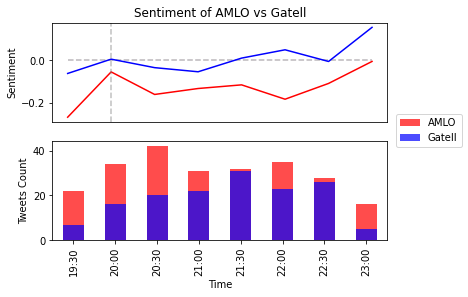

In [108]:
# Plot average word1 and word2 sentiment per day
fig, ax = plt.subplots(nrows=2)
ax[0].plot(sentiment_amlo_avg.index.strftime("%H:%M"), sentiment_amlo_avg, color = 'red')
# Plot average #word2 sentiment per day
ax[0].plot(sentiment_gatell_avg.index.strftime("%H:%M"), sentiment_gatell_avg, color = 'blue')
# ocurrencias por unidad de tiempo
count_amlo.plot(color = 'red',
           alpha=0.7, kind='bar', ax=ax[1])
count_gatell.plot(color = 'blue',
           alpha=0.7, kind='bar', ax=ax[1])
# ticks & labels
ax[0].set_ylabel('Sentiment')
ax[1].set_ylabel('Tweets Count')
ax[1].set_xlabel('Time')
# both major and minor ticks are affected
ax[0].tick_params(axis='x', which='both', bottom=False,
    labelbottom=False)
ax[1].set_xticklabels(sentiment_amlo_avg.index.strftime("%H:%M"),
                      rotation=90)

# horizontal line
ax[0].hlines(y=0, xmin=sentiment_amlo_avg.index.strftime("%H:%M").min(),
             xmax=sentiment_amlo_avg.index.strftime("%H:%M").max(),
             linestyles='dashed',
             colors='#BAB6BA')
# add vertical line
ax[0].axvline(x=pd.to_datetime('20:00').strftime("%H:%M"), color='gray', linestyle='--', alpha=0.5)

# title and legend
ax[0].set_title('Sentiment of AMLO vs Gatell')
#ax[0].legend(('AMLO', 'Gatell'),bbox_to_anchor=(1.0, 0.3),
#             numpoints=1, loc='lower left')
handles, labels = ax[1].get_legend_handles_labels()
labels =['AMLO', 'Gatell']
fig.legend(handles, labels, loc=(0.88,0.5),bbox_to_anchor=(0.92, 0.45))

plt.show()
fig.savefig('sentiment_amlo_gatell.png', dpi=300,
            bbox_inches='tight')